In [1]:
!conda install -y torchvision

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::graphviz==2.40.1=hefbbd9a_2
  - defaults/osx-64::pango==1.42.4=h060686c_0
  - defaults/noarch::python-graphviz==0.10.1=py_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

# All requested packages already installed.



In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import time

In [4]:
# plot function

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))


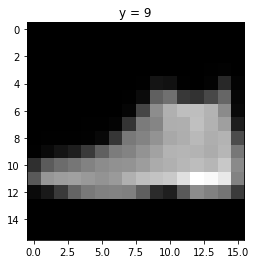

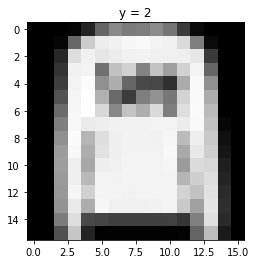

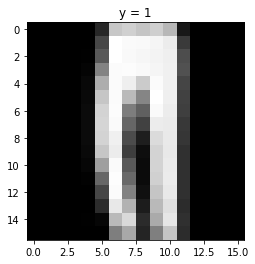

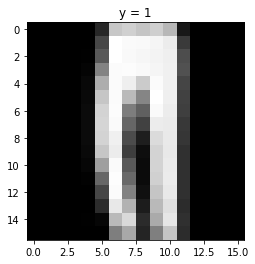

In [15]:
# Data Create

IMAGE_SIZE = 16

# Create a transform to resize image and convert to tensor
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

# Create Dataset from MNIST and apply composed transformation
dataset_train = dsets.FashionMNIST(root='.fashion/data', train=True, download=True, transform=composed)
dataset_val = dsets.FashionMNIST(root='.fashion/data', train=False, download=True, transform=composed)

for n, data_sample in enumerate(dataset_val):

    show_data(data_sample)
    plt.show()
    if n == 2:
        break

show_data(dataset_val[0])
show_data(dataset_val[1])
show_data(dataset_val[2])

In [16]:
class CNN(nn.Module):

    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.ELU = nn.ELU()
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2*4*4, 10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.ELU(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.ELU(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    # Outputs in each step
    def activations(self, x):
        
        z1 = self.cnn1(x)
        a1 = self.ELU(z1)
        out = self.maxpool1(a1)
        z2 = self.cnn2(out)
        a2 = self.ELU(z2)
        out1 = self.maxpool2(a2)
        out2 = out1.view(out1.size(0), -1)
        return z1, a1, out, z2, a2, out1, out2

In [17]:
class CNN_BatchNorm(nn.Module):
    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)  # To normalize conv2D
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.ELU = nn.ELU()
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2*4*4, 10)
        self.bn_fc1 = nn.BatchNorm1d(10)  # To normalize linear layer

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.ELU(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = self.ELU(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x


In [18]:
# Loss function 
criterion = nn.CrossEntropyLoss()

# train and val loader
train_loader = DataLoader(dataset=dataset_train, batch_size=100)
validation_loader = DataLoader(dataset=dataset_val, batch_size=100)

# Create model_BatchNorm object from CNN_BatchNorm class
model = CNN_BatchNorm(16, 32)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [19]:

cost_list = []
accuracy_list = []
N_test = len(dataset_val)
n_epochs = 5
for epoch in range(n_epochs):
    cost = 0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost += loss.item()
    correct = 0
    #  prediction on validation data
    model.eval()
    for x_test, y_test in validation_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)


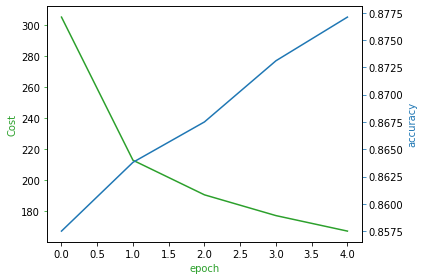

In [20]:
# Results

# Plot loss and accuracy
fig, ax1 = plt.subplots()
color = 'tab:green'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()